In [18]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import joblib
np.random.seed(42)
tf.random.set_seed(42)

In [19]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                  )

In [20]:
training_set = train_datagen.flow_from_directory('/home/student/Downloads/SEMINAR/LC25000/lung_colon_image_set/lung_rgb',
                                                 target_size = (128, 128),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                shuffle = False)

Found 15000 images belonging to 3 classes.


In [21]:
# Download VGG16 weights (if not already downloaded)
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(weights_path):
    base_model = VGG16(weights='imagenet', include_top=False)
    base_model.save_weights(weights_path)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Build a simplified VGG16-like model
def build_vgg16_model(input_shape):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(1, activation='softmax'))  # Binary classification, so use sigmoid activation

    return model

# Specify input shape
input_shape = (128, 128, 3)

# Build the model
vgg16_model = build_vgg16_model(input_shape)

# Compile the model
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
vgg16_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                 

In [23]:
import numpy as np

def extract_features(model, data_generator):
    # Remove the last dense layer (output layer)
    model.pop()

    # Freeze the weights of the remaining layers
    for layer in model.layers:
        layer.trainable = False
    
    # Extract features for each image in the data generator
    features_list = []
    total_images = len(data_generator.filenames)
    
    # Calculate the number of batches needed
    num_batches = total_images // data_generator.batch_size
    remaining_samples = total_images % data_generator.batch_size
    
    # Extract features for full batches
    for i in range(num_batches):
        images, _ = next(data_generator)
        batch_features = model.predict(images)
        features_list.append(batch_features)
    
    # Extract features for the remaining samples
    if remaining_samples > 0:
        images, _ = next(data_generator)
        batch_features = model.predict(images[:remaining_samples])
        features_list.append(batch_features)

    # Concatenate features from all batches
    return np.concatenate(features_list, axis=0)

# Example usage
# Assuming vgg16_model is your VGG16 model and training_set is your data generator
weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg16_model.load_weights(weights_path, by_name=True)  # Load weights only once
colon_features = extract_features(vgg16_model, training_set)

# Now, you can proceed with flattening and applying logistic regression
flat_features = colon_features.reshape((colon_features.shape[0], -1))


1/1 [==============================] - 0s 331ms/step


Updated CSV file with predicted labels saved as: /home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions.csv
Final Test Accuracy: 87.64%
Classification Report:
                              precision    recall  f1-score   support

         Lung adenocarcinoma       0.83      0.80      0.82      1524
          Lung benign tissue       0.99      0.98      0.99      1492
Lung squamous cell carcinoma       0.82      0.84      0.83      1484

                    accuracy                           0.88      4500
                   macro avg       0.88      0.88      0.88      4500
                weighted avg       0.88      0.88      0.88      4500



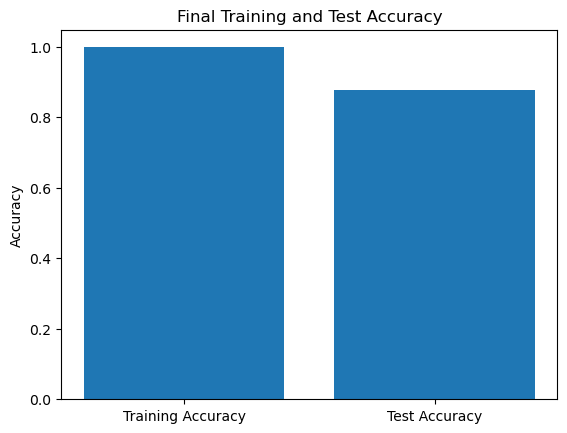

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib
import pandas as pd

def train_and_evaluate_logistic_regression(features, labels, test_size=0.3, random_state=42, regularization_strength=1.0):
    # Split the data into training and testing sets with a fixed random seed
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize logistic regression model with regularization
    logreg_model = LogisticRegression(max_iter=1000, warm_start=True, C=regularization_strength, random_state=42)

    # Lists to store training and test accuracy at each iteration
    training_accuracy = []
    test_accuracy = []

    # Train logistic regression model and record accuracy at each iteration
    for i in range(1, 101):  # Train for 100 iterations
        logreg_model.fit(X_train_scaled, y_train)
        
        # Training accuracy
        y_train_pred = logreg_model.predict(X_train_scaled)
        training_accuracy.append(accuracy_score(y_train, y_train_pred))
        
        # Test accuracy
        y_test_pred = logreg_model.predict(X_test_scaled)
        test_accuracy.append(accuracy_score(y_test, y_test_pred))

    # Predict labels for the entire dataset
    all_features_scaled = scaler.transform(features)
    all_predicted_labels = logreg_model.predict(all_features_scaled)

    # Add predicted labels to the original CSV file
    original_csv = pd.read_csv('/home/student/Downloads/SEMINAR/LC25000/seminar_lung.csv')
    original_csv['Predicted_Labels'] = all_predicted_labels

    # Save the updated CSV file with predicted labels
    updated_csv_filename = '/home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions.csv'
    original_csv.to_csv(updated_csv_filename, index=False)
    print(f"Updated CSV file with predicted labels saved as: {updated_csv_filename}")

    # Evaluate the final model on the test set
    y_pred = logreg_model.predict(X_test_scaled)
    final_test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

    # Classification report
    print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=['Lung adenocarcinoma', 'Lung benign tissue','Lung squamous cell carcinoma'])
    print(report)

    # Save the scaler and the trained logistic regression model
    joblib.dump(scaler, 'scaler.pkl')
    joblib.dump(logreg_model, 'logreg_model.pkl')

    # Plot bar graph for final training and test accuracy
    plt.bar(['Training Accuracy', 'Test Accuracy'], [training_accuracy[-1], final_test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Final Training and Test Accuracy')
    plt.show()

    # Return the trained logistic regression model and the scaler
    return logreg_model, scaler

# Example usage with regularization strength of 0.1
logreg2_model, trained_scaler = train_and_evaluate_logistic_regression(flat_features, training_set.labels, random_state=42, regularization_strength=0.1)


In [25]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

# # Load the CSV file into a DataFrame
# df = pd.read_csv('/home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions.csv')

# # Assuming your CSV columns are named 'true_labels' and 'predicted_labels'
# true_labels = df['label']
# predicted_labels = df['Predicted_Labels_logistic_regression']

# # Create a confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Plot the confusion matrix using seaborn with a different color map ('viridis')
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=True, yticklabels=True)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix for Logistic Regression")
# plt.show()


In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load your CSV file
df = pd.read_csv('/home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions.csv')


In [54]:

# Assuming 'label' is the original label column and 'Predicted_Labels_logistic_regression' is the predicted label column
original_labels = df['label']
predicted_labels = df['Predicted_Labels_logistic_regression']


# Create a confusion matrix
conf_matrix = confusion_matrix(original_labels, predicted_labels)



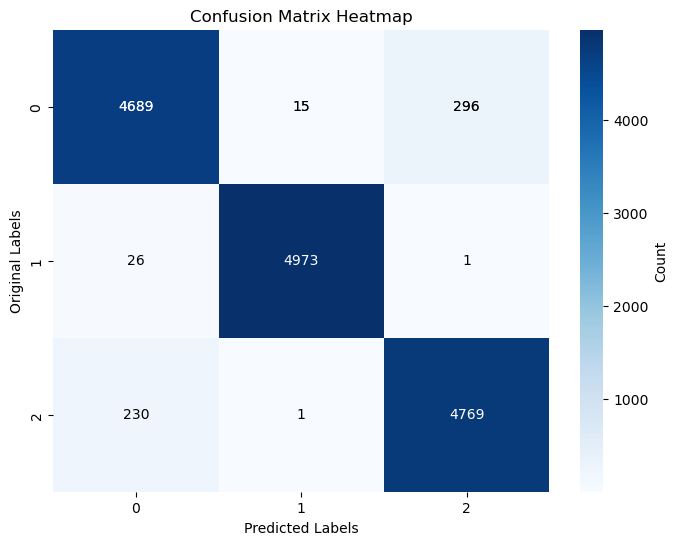

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

# Create a custom heatmap
sns.heatmap(np.array(conf_matrix),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2],
            cbar_kws={'label': 'Count'})

# Add values to each cell manually
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        if i==j:#(i,j) in [(0,0),(1,1),(2,2)]:
            textColor='White'
        else:
            textColor='Black'
        ax.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha='center', va='center', color=textColor, fontsize=10)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('Original Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

Updated CSV file with predicted labels saved as: /home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions_rf.csv
Final Test Accuracy: 78.42%
Classification Report:
                              precision    recall  f1-score   support

         Lung adenocarcinoma       0.70      0.65      0.67      1524
          Lung benign tissue       0.94      0.95      0.94      1492
Lung squamous cell carcinoma       0.71      0.75      0.73      1484

                    accuracy                           0.78      4500
                   macro avg       0.78      0.79      0.78      4500
                weighted avg       0.78      0.78      0.78      4500



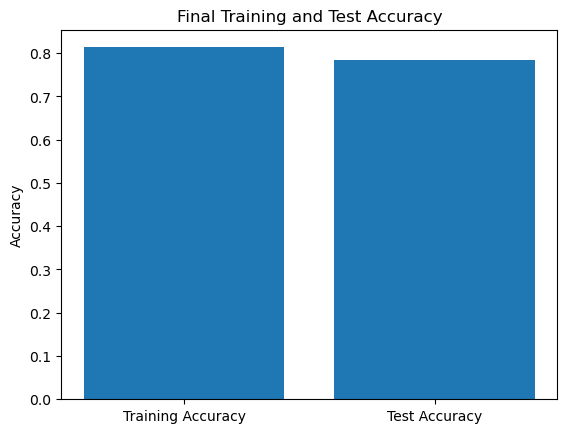

In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
import pandas as pd

def train_and_evaluate_random_forest(features, labels, test_size=0.3, random_state=42, n_estimators=100, max_depth=5):
    # Split the data into training and testing sets with a fixed random seed
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Lists to store training and test accuracy at each iteration
    training_accuracy = []
    test_accuracy = []

    # Train Random Forest model and record accuracy at each iteration
    for i in range(1, 101):  # Train for 100 iterations
        rf_model.fit(X_train, y_train)
        
        # Training accuracy
        y_train_pred = rf_model.predict(X_train)
        training_accuracy.append(accuracy_score(y_train, y_train_pred))
        
        # Test accuracy
        y_test_pred = rf_model.predict(X_test)
        test_accuracy.append(accuracy_score(y_test, y_test_pred))

    # Predict labels for the entire dataset
    all_predicted_labels = rf_model.predict(features)

    # Add predicted labels to the original CSV file
    original_csv = pd.read_csv('/home/student/Downloads/SEMINAR/LC25000/seminar_lung.csv')
    original_csv['Predicted_Labels_rf'] = all_predicted_labels

    # Save the updated CSV file with predicted labels
    updated_csv_filename = '/home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions_rf.csv'
    original_csv.to_csv(updated_csv_filename, index=False)
    print(f"Updated CSV file with predicted labels saved as: {updated_csv_filename}")

    # Evaluate the final model on the test set
    y_pred = rf_model.predict(X_test)
    final_test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Final Test Accuracy: {final_test_accuracy * 100:.2f}%")

    # Classification report
    print("Classification Report:")
    report = classification_report(y_test, y_pred, target_names=['Lung adenocarcinoma', 'Lung benign tissue','Lung squamous cell carcinoma'])
    print(report)

    # Save the trained Random Forest model
    joblib.dump(rf_model, 'rf_model.pkl')

    # Plot bar graph for final training and test accuracy
    plt.bar(['Training Accuracy', 'Test Accuracy'], [training_accuracy[-1], final_test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Final Training and Test Accuracy')
    plt.show()

    # Return the trained Random Forest model
    return rf_model

# Example usage with n_estimators=100 and max_depth=None
rf_model = train_and_evaluate_random_forest(flat_features, training_set.labels, random_state=42, n_estimators=100, max_depth=3)


In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load your CSV file
df = pd.read_csv('/home/student/Downloads/SEMINAR/LC25000/seminar_lung_predictions.csv')


In [59]:

# Assuming 'label' is the original label column and 'Predicted_Labels_logistic_regression' is the predicted label column
original_labels = df['label']
predicted_labels = df['Predicted_Labels_rf']


# Create a confusion matrix
conf_matrix = confusion_matrix(original_labels, predicted_labels)



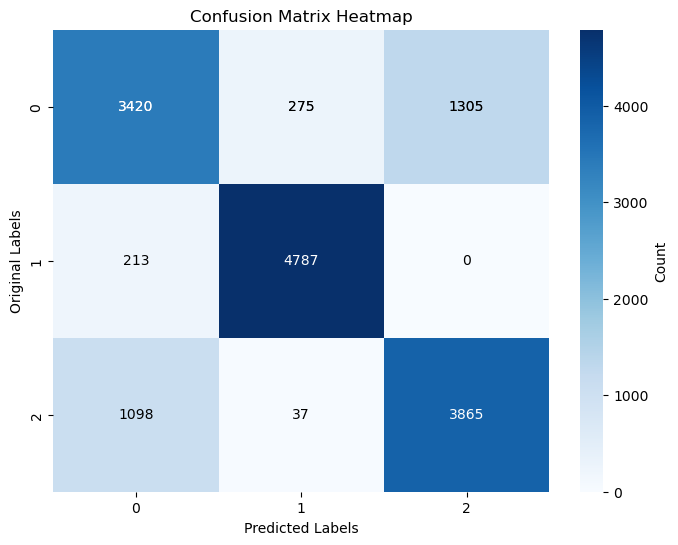

In [60]:
fig, ax = plt.subplots(figsize=(8, 6))

# Create a custom heatmap
sns.heatmap(np.array(conf_matrix),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=[0, 1, 2],
            yticklabels=[0, 1, 2],
            cbar_kws={'label': 'Count'})

# Add values to each cell manually
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        if i==j:#(i,j) in [(0,0),(1,1),(2,2)]:
            textColor='White'
        else:
            textColor='Black'
        ax.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha='center', va='center', color=textColor, fontsize=10)

# Set labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('Original Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()